## Table of contents:
* Initial Setup
* Data Loading and Preprocessing
    * Data Variables
* Model Instantiation
* Optimizer and Scheduler
* Train and Evaluation Loop
    * Save the model and plot the losses (**1 Point**)
* Test Loop  
* Human Pose Visualization (**2 Points**)
* Report and Parameter Fine-Tuning Analysis  (**4 Points**)
* Calculating MPJPE for a Specific Frame  (**2 Points**)
* Iterative Mechanism (**3 Points**)
* YOUR custom model (**3 Points**)
    * Performance BONUS (**Up to 2 Points**)



## Initial Setup
Run the following two cellls to sync with Google Drive only if you run from Google Colab.

*Note: we recommend using Google Colab for this specific homework, since the training phase will require a GPU*

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AML_HW3/Practice

/content/drive/MyDrive/AML_HW3/Practice


Welcome to this guide on training, testing, and fine-tuning a deep learning model. Deep learning is at the forefront of artificial intelligence, with applications spanning image recognition, natural language processing, and more.

Throughout this assignment, you'll:

1. **Prepare Data:** Preprocess and load the data.

2. **Use Neural Networks:** Instantiate a neural network architecture.

3. **Train Models:** Utilize optimization, loss functions, and backpropagation.

4. **Evaluate Performance:** Assess model performance, prevent overfitting, and underfitting.

5. **Fine-Tune Models:** Explore hyperparameter tuning.

In [ ]:
from utils import h36motion3d as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.autograd
import torch
import numpy as np
from utils.loss_funcs import *
from utils.data_utils import define_actions
from utils.h36_3d_viz import visualize
import time

import torch.nn.functional as F

import os

from utils.pos_embed_p import Pos_Embed
import torch.nn as nn

In [ ]:
# Use GPU if available, otherwise stick with cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device,  '- Type:', torch.cuda.get_device_name(0))

Using device: cuda - Type: Tesla T4


## Data Loading and Preprocessing

For this homework, you will use [Human3.6M](https://vision.imar.ro/human3.6m/pami-h36m.pdf), which is a large-scale dataset of 3.6 million accurate 3D human poses acquired by recording the performance of five female and six male subjects under four different viewpoints. The dataset includes:
- Synchronized image.
- Human motion capture.
- Time of flight (depth) data.
- Accurate 3D body scans of all the subject actors involved.

The dataset aims to provide diverse motions and poses encountered in typical human activities, with additional data to train realistic human sensing systems.

![picture](https://drive.google.com/uc?export=view&id=1nyD1_F3r1ctexKFGDmhy2Q9SX_2Z_bpS)

For this assignment, we will leverage the rich **motion data** (See in the figure above) provided by H3.6M to perform a task known as *motion prediction*. Motion prediction involves using historical motion data to forecast future movements. This task is fundamental in human-robot interaction, animation, and sports analytics applications.

### Data Variables

Each created sequence has the shape (35, 17, 3), where:
- Number of observed sequences and number of sequences to predict: $N_{obs}+N_{pred} = 10 + 25 = 35$;
- Number of body joints to consider: $J=22$;
- Spatial coordinates: $(x,y,z) = 3$.


The original data provides high-resolution progressive scan videos at 50 Hz. However, the dataset has been downsampled to 25 Hz for research purposes. This means that 25 frames of motion data are provided per second.

*Note: the figure above shows 18 joints, however the dataset contains 32. For this specific case we will consider 22 joints, ignoring some of the finer ones (e.g. foot tip, hand tip, etc)*


In [ ]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)
output_n=25 # number of frames to predict on
input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22


#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2

Load Dataset

*Note: It will take you ~ 5 minutes*

In [ ]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

Loading Train Dataset...


/content/drive/MyDrive/AML_HW3/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Loading Validation Dataset...


Following we create a torch dataloader that create the batches for each epoch.

In [ ]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

>>> Training dataset length: 180077
>>> Validation dataset length: 28110


## Model instantiation


Each sequence comprises an **observed** part to train the Encoder and a part that attempts to predict the **future** sequence, the Decoder.

Generally, the standard setup plans to use the first 10 sequences of poses ($N_{obs}=10$) for the observation and the following 25 ($N_{pred} = 25$) for the prediction.


We create an instance of a custom Spatio-Temporal transformer with the chosen configuration.

(*Note: explore the model in ./models/sttr/sttformer.py*)

Then we allocate it to the GPU for forward and backward accelerated computation.

In [ ]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

Using device: cuda
total number of parameters of the network is: 14999


## Optimizer and Scheduler

As we embark on training deep learning models for motion prediction using the H3.6M dataset, it's essential to recognize several key parameters and components that significantly impact the training phase:

- **Learning Rate:** This parameter determines the convergence speed during optimization.

- **Batch Size:** It influences model generalization and training efficiency.

- **Number of Epochs:** The number of training iterations affects model learning.

- **Loss Function:** The choice of loss function directly affects learning and final performance.

- **Optimizer:** The optimization algorithm used (e.g., Adam, SGD) impacts gradient descent during training.

- **Milestones and Gamma:** These parameters control learning rate schedules, allowing for adaptive adjustments during training.

- **Weight Decay:** It regulates the impact of model parameters during optimization.

- **Scheduler:** Scheduler strategies (e.g., StepLR, ReduceLROnPlateau) manage learning rate adaptation during training.

In [ ]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10,30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [ ]:
clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

## Train and Evaluation Loop

The **loss** and **metric** used during training and evaluation respectively, compare the predicted joint positions to ground truth joint positions for all frames, which is typically referred to as the **Average Mean Per
Joint Position Error (A-MPJPE)** can be seen as an $L_2$. This loss quantifies the dissimilarity between the predicted and ground truth joint positions by measuring the squared Euclidean distance between corresponding joint positions.

\begin{align*}
A-MPJPE &= \frac{1}{N_{pred}} \sum_{i=1}^{N_{pred}} \left(\frac{1}{J} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|^2\right)
\end{align*}

$$where:$$

\begin{align*}
P_{\text{predicted}} &: \text{Set of predicted joint positions estimated by the model.} \\
P_{\text{gt}} &: \text{Corresponding set of ground truth joint positions.} \\
\end{align*}

*Note: If you restart the training for any reason, remember to instantiate the model and the optimizer again. This will avoid continuing the training with the initialized weights of the previous one*


### Save the model and plot the losses (1 Point)

**Objective:** In this exercise, you will practice implementing a code snippet to save your deep learning model's checkpoints and visualize the training and validation loss on the same plot every 5 epochs during model training.

Your task is to implement the following:

- Set up a mechanism to save the model's checkpoints (weights and architecture) during training. These checkpoints should be saved periodically, say, **every 5 epochs**.

- Create a plot displaying the training and validation losses on the same graph. The x-axis should represent the number of epochs, and the y-axis should represent the loss values. The training and validation losses should be plotted as separate lines on the same graph.

- Ensure that the code saves the model's checkpoints in a specified directory, including the model's architecture and weights, and that the loss plot is displayed.

Analyze the loss plot to gain insights into how your model is learning over time and whether there are any signs of overfitting or underfitting.

*Note: see the Pytorch Documentation on how to save your model's checkpoints.*


In [ ]:
def train(data_loader,vald_loader, path_to_save_model=None):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  # Initialize lists to store data from each checkpoint
  train_losses = []
  val_losses = []

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs-1):
      running_loss=0
      n=0
      model.train()
      for cnt,batch in enumerate(data_loader):
          batch=batch.float().to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

          optimizer.zero_grad()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)


          loss=mpjpe_error(sequences_predict,sequences_gt)


          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(),clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim

      train_loss.append(running_loss.detach().cpu()/n)
      model.eval()
      with torch.no_grad():
          running_loss=0
          n=0
          for cnt,batch in enumerate(vald_loader):
              batch=batch.float().to(device)
              batch_dim=batch.shape[0]
              n+=batch_dim


              sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
              sequences_gt=batch[:, input_n:input_n+output_n, dim_used].view(-1,output_n,len(dim_used)//3,3)

              sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
              loss=mpjpe_error(sequences_predict,sequences_gt)

              if cnt % log_step == 0:
                        print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()))
              running_loss+=loss*batch_dim
          val_loss.append(running_loss.detach().cpu()/n)
          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n

      if use_scheduler:
        scheduler.step()

      # save and plot model every 5 epochs
      '''
      Insert your code below. Use the argument path_to_save_model to save the model to the path specified.
      '''

      if save_and_plot and (epoch + 1) % 5 == 0:

        torch.save(model.state_dict(), model_path+model_name+'_epoch_'+str(epoch+1)+'.pt')
        train_losses.append(train_loss[-1])
        val_losses.append(val_loss[-1])

  epochs=[5,10,15,20,25,30,35,40]

  # Create the plot
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')

  plt.legend()

  # Display the plot
  plt.grid(True)
  plt.show()


[Epoch: 1, Iteration:     1]  training loss: 559.212
[Epoch: 1, Iteration:   201]  training loss: 143.068
[Epoch: 1, Iteration:   401]  training loss: 119.356
[Epoch: 1, Iteration:   601]  training loss: 109.212
[Epoch: 1, Iteration:     1]  validation loss: 119.530
[Epoch: 2, Iteration:     1]  training loss: 114.200
[Epoch: 2, Iteration:   201]  training loss: 106.197
[Epoch: 2, Iteration:   401]  training loss: 105.069
[Epoch: 2, Iteration:   601]  training loss: 103.193
[Epoch: 2, Iteration:     1]  validation loss: 94.937
[Epoch: 3, Iteration:     1]  training loss: 98.467
[Epoch: 3, Iteration:   201]  training loss: 100.244
[Epoch: 3, Iteration:   401]  training loss: 98.622
[Epoch: 3, Iteration:   601]  training loss: 104.975
[Epoch: 3, Iteration:     1]  validation loss: 99.809
[Epoch: 4, Iteration:     1]  training loss: 104.647
[Epoch: 4, Iteration:   201]  training loss: 98.764
[Epoch: 4, Iteration:   401]  training loss: 98.423
[Epoch: 4, Iteration:   601]  training loss: 9

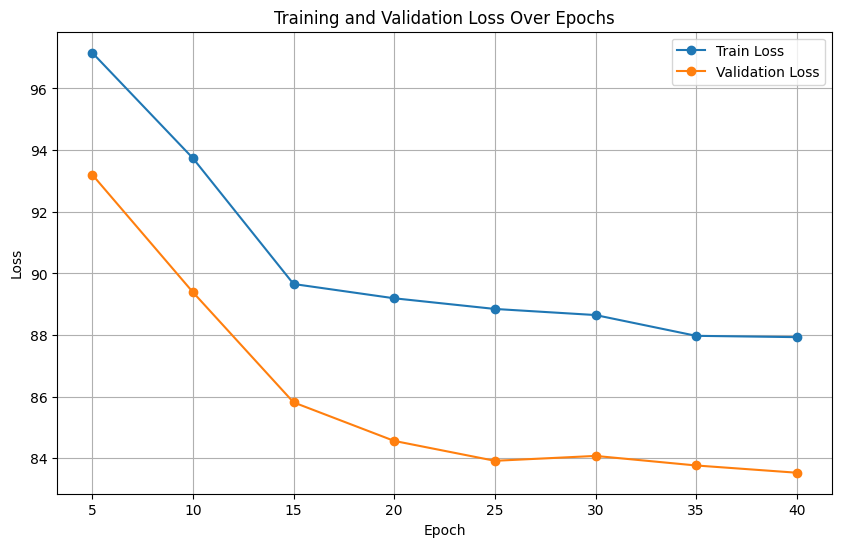

In [ ]:
save_and_plot = True # save the model and plot the loss. Change to True if you want to save the model and plot the loss

# launch training
train(data_loader,vald_loader, path_to_save_model=model_path)

The train and validation loss plot is useful to visualize what is happening during the training phase. In particular, we use it as a visualization tool to avoid the training phase to bring the model to overfitting. This is exactly the role of the validation set.

In this case, we observe that the validation loss and the train loss decrease together, as they are supposed too.

For those reasons, we decide to test the model at epoch 40, that corresponds to the point with lowest loss value.

## Test Loop

After training and validation, the test loop is the final phase that evaluates the model's performance on an entirely independent dataset known as the test dataset. This dataset is distinct from the training and validation data, ensuring unbiased assessment. The test loop provides a reliable estimate of how well the model will perform in real-world scenarios, confirming that any improvements observed during training and validation are not due to overfitting or chance. It's a crucial step before deploying the model in practical applications.

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          #sequences_predict = model(sequences_train)
          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss=mpjpe_error(all_joints_seq.view(-1,output_n,32,3),sequences_gt.view(-1,output_n,32,3))
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)


*Note: Your results should be better than 95 millimiters on average*

In [ ]:
ckpt_path = './checkpoints/h36m_3d_25frames_ckpt_epoch_40.pt' # Change the epoch according to the validation curve
test(ckpt_path)

model loaded


/content/drive/MyDrive/AML_HW3/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


walking :  68.6
eating :  63.5
smoking :  64.2
discussion :  90.7
directions :  81.7
greeting :  105.4
phoning :  78.9
posing :  119.0
purchases :  104.0
sitting :  91.1
sittingdown :  117.8
takingphoto :  91.0
waiting :  86.7
walkingdog :  112.9
walkingtogether :  61.4
Average: 89.1
Prediction time:  0.0049271658062934875


## Human Pose Visualization  (**2 Points**)

The qualitative results are as important as the quantitative ones. In this section, you will visualize and compare the predicted poses with the ground truth ones.
For simplicity, you will visualize only the first predicted pose and the ground truth.

Ideally, the same plot should show the predicted pose in red and the ground truth one in green.

*Note: you will find which nodes are connected in the file ./models/skeleton_connection.py*

In [ ]:
# This code corresponds to the one present in the file from which the function visualize is imported
# It is reported here because some modification were made, highlighted with some comments

#!/usr/bin/env python
# coding: utf-8

import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from utils import h36motion3d as datasets
from utils.loss_funcs import mpjpe_error
from utils.data_utils import define_actions

def create_pose(ax,plots,vals,pred=True,update=False):


    # [16, 20, 23, 24, 28, 31] IGNORE
    # [13, 19, 22, 13, 27, 30] EQUAL
    # h36m 32 joints(full)
    connect = [
            (1, 2), (2, 3), (3, 4), (4, 5),
            (6, 7), (7, 8), (8, 9), (9, 10),
            (0, 1), (0, 6),
            (6, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22),
            (1, 25), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30),
            (24, 25), (24, 17),
            (24, 14), (14, 15)
    ]
    LR = [
            False, True, True, True,
            True, True, False, False,
             False, False,
            False, True, True, True, True, True, True,
            False, False, False, False, False, False, False, True,
            False, True, True, True, True,
            True, True
    ]


# Start and endpoints of our representation
    I   = np.array([touple[0] for touple in connect])
    J   = np.array([touple[1] for touple in connect])
# Left / right indicator
    LR  = np.array([LR[a] or LR[b] for a,b in connect])
    if pred:
        lcolor = "green"  #colors changed
        rcolor = "green"
    else:
        lcolor = "red"
        rcolor = "red"

    for i in np.arange( len(I) ):
        x = np.array( [vals[I[i], 0], vals[J[i], 0]] )
        z = np.array( [vals[I[i], 1], vals[J[i], 1]] )
        y = np.array( [vals[I[i], 2], vals[J[i], 2]] )
        if not update:

            if i ==0:
                plots.append(ax.plot(x, y, z, lw=2,linestyle='--' ,c=lcolor if LR[i] else rcolor,label=['Input Frames' if not pred else 'Predicted Frames']))
            else:
                plots.append(ax.plot(x, y, z, lw=2,linestyle='--', c=lcolor if LR[i] else rcolor))

        elif update:
            plots[i][0].set_xdata(x)
            plots[i][0].set_ydata(y)
            plots[i][0].set_3d_properties(z)
            plots[i][0].set_color(lcolor if LR[i] else rcolor)

    return plots
   # ax.legend(loc='lower left')

def update(num,data_gt,data_pred,plots_gt,plots_pred,fig,ax):

    gt_vals=data_gt[num]
    pred_vals=data_pred[num]
    plots_gt=create_pose(ax,plots_gt,gt_vals,pred=False,update=True)
    plots_pred=create_pose(ax,plots_pred,pred_vals,pred=True,update=True) ########à

    r = 0.75
    xroot, zroot, yroot = gt_vals[0,0], gt_vals[0,1], gt_vals[0,2]
    ax.set_xlim3d([-r+xroot, r+xroot])
    ax.set_ylim3d([-r+yroot, r+yroot])
    ax.set_zlim3d([-r+zroot, r+zroot])
    #ax.set_title('pose at time frame: '+str(num))
    #ax.set_aspect('equal')

    return plots_gt ,plots_pred ##################

def visualize(input_n,output_n,visualize_from,path,modello,device,n_viz,skip_rate,actions):

    actions=define_actions(actions)

    for action in actions:

        if visualize_from=='train':
            loader=datasets.Datasets(path,input_n,output_n,skip_rate, split=0,actions=[action])
        elif visualize_from=='validation':
            loader=datasets.Datasets(path,input_n,output_n,skip_rate, split=1,actions=[action])
        elif visualize_from=='test':
            loader=datasets.Datasets(path,input_n,output_n,skip_rate, split=2,actions=[action])

        dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                        26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                        46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                        75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
      # joints at same loc
        joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
        index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
        joint_equal = np.array([13, 19, 22, 13, 27, 30])
        index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))


        loader = DataLoader(
        loader,
        batch_size=1,
        shuffle = True,
        num_workers=0)

        for cnt,batch in enumerate(loader):
            batch = batch.to(device)

            all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

            sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
            sequences_gt=batch[:, input_n:input_n+output_n, :]

            sequences_predict=modello(sequences_train).contiguous().view(-1,output_n,len(dim_used)) # removed .permute(0,1,3,2)

            all_joints_seq[:,:,dim_used] = sequences_predict

            all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]


            all_joints_seq=all_joints_seq.view(-1,output_n,32,3)

            sequences_gt=sequences_gt.view(-1,output_n,32,3)

            loss=mpjpe_error(all_joints_seq,sequences_gt)# # both must have format (batch,T,V,C)

            data_pred=torch.squeeze(all_joints_seq,0).cpu().data.numpy()/1000 # in meters
            data_gt=torch.squeeze(sequences_gt,0).cpu().data.numpy()/1000

            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')  # substitute Axes3D(fig) with this line
            vals = np.zeros((32, 3)) # or joints_to_consider
            gt_plots=[]
            pred_plots=[]

            gt_plots=create_pose(ax,gt_plots,vals,pred=False,update=False)
            pred_plots=create_pose(ax,pred_plots,vals,pred=True,update=False)

            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
            ax.set_axis_off()
            ax.legend(loc='lower left')

            ax.set_xlim3d([-1, 1.5])
            ax.set_xlabel('X')

            ax.set_ylim3d([-1, 1.5])
            ax.set_ylabel('Y')

            ax.set_zlim3d([0.0, 1.5])
            ax.set_zlabel('Z')
           # ax.set_title('loss in mm is: '+str(round(loss.item(),4))+' for action : '+str(action)+' for '+str(output_n)+' frames')

            plt.rcParams['grid.color'] = "white" # COMMENT FOR GRID

            line_anim = animation.FuncAnimation(fig, update, output_n, fargs=(data_gt,data_pred,gt_plots,pred_plots,
                                                                       fig,ax),interval=70, blit=False)

            plt.show()

            line_anim.save('human_viz2.gif',writer='pillow')

            if cnt==n_viz-1:
                break


In [ ]:
%%capture

'''
Insert your code below

'''
visualize(input_n, output_n, visualize_from, path, model, device, n_viz, skip_rate, actions_to_consider_test)


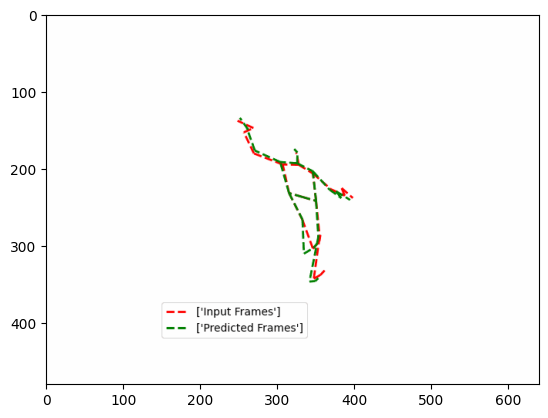

In [ ]:
from PIL import Image
gif_path = "./human_viz2.gif"
gif_image = Image.open(gif_path)

plt.imshow(gif_image)
#plt.axis('off')
plt.show()

## Report and Parameter Fine-Tuning Analysis  (**4 Points**)

**Objective:** In this exercise, you will analyze the results obtained from a deep learning model you previously trained and perform parameter fine-tuning to optimize its performance. The key considerations are learning rate, milestones, and weight decay. **You will also use tables and plots to visualize and interpret the outcomes.**

**Instructions:**

1. **Analysis:** Analyze the generated report and answer the following questions:
   - Is there evidence of overfitting or underfitting in the initial training results?
   - Are there fluctuations in training and validation loss or accuracy? If so, what might be causing them?
   - What can you infer from the initial learning rate, milestones, and weight decay settings?

2. **Parameter Fine-Tuning:** Based on your analysis, perform parameter fine-tuning to optimize model performance. Adjust the following parameters:
   - **Learning Rate:** Experiment with different learning rates (higher and lower values) to find an optimal rate.
   - **Milestones:** Modify the milestone values for adjusting the learning rate schedule.
   - **Weight Decay:** Explore different weight decay values.
   

3. **Re-Training:** Train the model with the adjusted hyperparameters. Record the training progress and generate a new report, including performance metrics and line plots as before.

4. **Final Analysis:** Analyze the results of the fine-tuned model and compare them with the initial training. Answer the following questions:
   - Has parameter fine-tuning improved model performance?
   - Did it mitigate overfitting or underfitting issues?
   - What can you conclude about the optimal hyperparameters for this task?


## Calculating MPJPE for a Specific Frame  (**2 Points**)


In this exercise, you will calculate the Mean Per Joint Position Error (MPJPE) for a specific frame. This skill is valuable for assessing the accuracy of your model's predictions at a particular moment.

\begin{align*}
\text{MPJPE}_t = \frac{1}{N} \sum_{j=1}^{J} \left\| P_{\text{predicted}_{t,j}} - P_{\text{gt}_{t,j}} \right\|
\end{align*}

Fixed the frame $t$, you will calculate the MPJPE for the predicted pose and the ground truth. Steps:

- Write a function that takes in input the predicted pose and the ground truth one and returns the MPJPE for a number of frames $t$. (e.g. the output could be a dictionary with the frame number as key and the MPJPE as value)
- Rewrite the test function to use the function you just wrote.
- Run the newly created test function for $t=[5, 10, 15, 25]$ and report the results in a table and plot.





In [ ]:
def mpjpe_per_frame(sequences_predict,sequences_gt,frames_to_consider):
    '''
    Insert your code below
    '''
    num_frames = len(frames_to_consider)

    pred = sequences_predict[:,frames_to_consider,:,:].permute(0,2,1,3)
    gt = sequences_gt[:,frames_to_consider,:,:].permute(0,2,1,3)

    batch_pred = pred.reshape(-1,num_frames,3)
    batch_gt = gt.reshape(-1,num_frames,3)

    means = torch.mean(torch.norm(batch_gt-batch_pred,2,2),0).cpu().numpy()

    return means

In [ ]:
### CHANGE ###
### ADD FRAMES_TO_CONSIDER IN INPUT
def test_per_frame(ckpt_path=None, frames_to_consider=[4, 9, 14, 24]):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0

    ####################################################################
    ############################## CHANGE ##############################
    # FOR EACH ACTION, A VECTOR OF len(frames_to_consider) 
    running_loss=np.zeros((len(actions),len(frames_to_consider)))
    ############################## CHANGE ##############################
    ####################################################################

    for i,action in enumerate(actions):
      n=0
      dataset_test = datasets.Datasets(path,input_n,output_n,skip_rate,split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+output_n,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+output_n, :]


          running_time = time.time()
          sequences_predict=model(sequences_train).view(-1, output_n, joints_to_consider, 3)
          totalll += time.time()-running_time
          counter += 1
          sequences_predict=sequences_predict.contiguous().view(-1,output_n,len(dim_used))

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          '''
          Insert your code below.
          The function mpjpe_per_frame should return the loss for each frame in the sequence. (e.g. a dictionary with keys the frames and values the loss for each frame)
          Keep a tab of the running loss for each frame and the number of frames in the sequence.
          '''
          loss=mpjpe_per_frame(all_joints_seq.view(-1,output_n,32,3),sequences_gt.view(-1,output_n,32,3),frames_to_consider)*batch_dim
          # FOR EACH ACTION, SUM THE LOSSES IN THE RELATIVE ROW
          running_loss[i]+=loss

          accum_loss+=loss
      '''
      Insert your code below.
      Average the loss over all the frames in the sequence and print the results.
      '''
      running_loss[i]/=n
      print("Action: ", action)
      # WE USE TABULATE, MAYBE WE'RE A BIT SNOOTY
      print(tabulate([running_loss], headers=list(map(lambda x: x+1,frames_to_consider)), tablefmt='fancy_grid'))
      n_batches+=n

    print("\n")
    print("Average")
    print(tabulate([accum_loss/n_batches], headers=list(map(lambda x: x+1,frames_to_consider)), tablefmt='fancy_grid'))
    print('Prediction time: ', totalll/counter)
    # Create a box plot with the results
    fig = plt.figure(figsize =(10, 6))
    ax = fig.add_subplot(111)
    bplot = ax.boxplot(running_loss,patch_artist=True,labels=['STEP 5', 'STEP 10', 'STEP 15', 'STEP 25'])

    colors = ['pink', 'lightblue', 'lightgreen']
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    ax.yaxis.grid(True)
    plt.title('Running Loss')
    ax.set_xlabel('STEP')
    ax.set_ylabel('LOSS')
    plt.show()


model loaded


/content/drive/.shortcut-targets-by-id/1IDvOhof2-aw4ts2xN9XtZkYnjU34sNPy/AML_HW3/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


Action:  walking
╒═════════╤═════════╤═════════╤═════════╕
│       5 │      10 │      15 │      25 │
╞═════════╪═════════╪═════════╪═════════╡
│ 50.6956 │ 63.7423 │ 75.8451 │ 87.4945 │
╘═════════╧═════════╧═════════╧═════════╛
Action:  eating
╒═════════╤═════════╤═════════╤═════════╕
│       5 │      10 │      15 │      25 │
╞═════════╪═════════╪═════════╪═════════╡
│ 37.0351 │ 52.6704 │ 67.3362 │ 87.8263 │
╘═════════╧═════════╧═════════╧═════════╛
Action:  smoking
╒═════════╤═════════╤════════╤═════════╕
│       5 │      10 │     15 │      25 │
╞═════════╪═════════╪════════╪═════════╡
│ 41.5003 │ 55.5279 │ 68.247 │ 82.3815 │
╘═════════╧═════════╧════════╧═════════╛
Action:  discussion
╒═════════╤═════════╤═════════╤═════════╕
│       5 │      10 │      15 │      25 │
╞═════════╪═════════╪═════════╪═════════╡
│ 51.9786 │ 81.6061 │ 102.887 │ 123.831 │
╘═════════╧═════════╧═════════╧═════════╛
Action:  directions
╒═════════╤═════════╤═════════╤═════════╕
│       5 │      10 │      15 │  

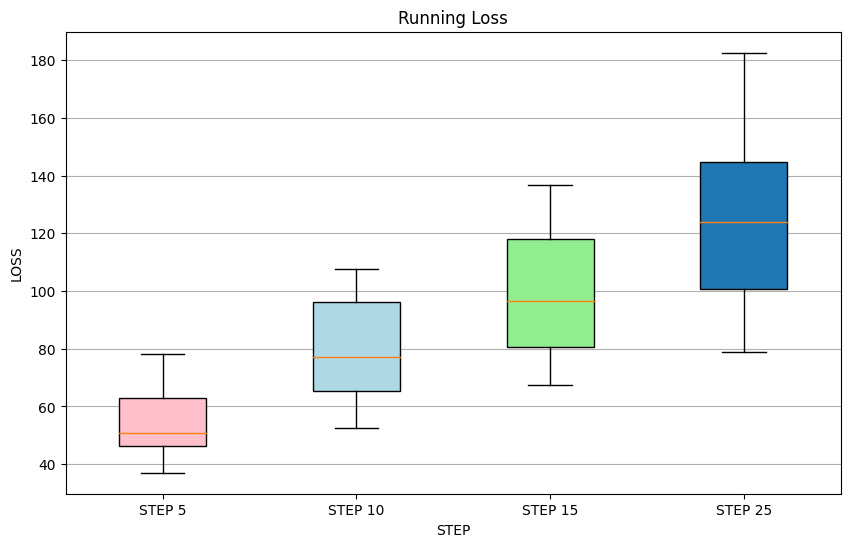

In [ ]:
'''
Insert your code below where you want to load the model and test it.
You need to specify the path to the model checkpoint file and call the test function.
'''
# ckpt_path = ...
test_per_frame(ckpt_path="checkpoints/h36m_3d_25frames_ckpt_epoch_40.pt")

It's easy to note that the more the steps are the more the losses are higher.This issue is due to a couple of reasons:

1. obviusly the firsts predicted steps strongly depend by the training steps, while the latter ones may be influenced by other factors during time;    
2. the errors in the firsts steps propagate in the following ones causing very worst results.

The mean error in the fifth step is around 50 mm, while in twenty-fifth one is more then double around 120 mm.
It's evident also the increase of the variability of the results, which means an higher uncertanty about the real values.

## Iterative Mechanism (**3 Points**)

In this exercise, you will explore the concept of an iterative mechanism and its adaptability when the model's output length changes. You will start with a model designed to produce 25 output frames but adapt it to generate only 10. The exercise will involve modifying and re-training the model for the new output length. During test time, the model will generate 10 frames and then use them as input to generate the successive 10 frames, and so on, until the desired number of frames is reached. In this case, you are asked to generate 25 frames.

The steps are as follows:
- Change the model's output length from 25 to 10.
- Re-train the model.
- Rewrite the test function to generate 25 frames using the iterative mechanism.
- Generate a new report and compare the results to the baseline model.

In [ ]:
# # Arguments to setup the datasets
datas = 'h36m' # dataset name
path = './data/h3.6m/h3.6m/dataset'
input_n=10 # number of frames to train on (default=10)

'''
Insert your code below
'''
output_n=10  # number of frames to predict on

input_dim=3 # dimensions of the input coordinates(default=3)
skip_rate=1 # # skip rate of frames
joints_to_consider=22

#FLAGS FOR THE TRAINING
mode='train' #choose either train or test mode

batch_size_test=8
model_path_iterative= './checkpoints/' # path to the model checkpoint file

actions_to_consider_test='all' # actions to test on.
model_name = datas+'_3d_'+str(output_n)+'frames_ckpt' #the model name to save/load

#FLAGS FOR THE VISUALIZATION
actions_to_consider_viz='all' # actions to visualize
visualize_from='test'
n_viz=2


In [ ]:
# Load Data
print('Loading Train Dataset...')
dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=0)
print('Loading Validation Dataset...')
vald_dataset = datasets.Datasets(path,input_n,output_n,skip_rate, split=1)

#! Note: Ignore warning:  "VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences"

In [ ]:
batch_size=256

print('>>> Training dataset length: {:d}'.format(dataset.__len__()))
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)#

print('>>> Validation dataset length: {:d}'.format(vald_dataset.__len__()))
vald_loader = DataLoader(vald_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

In [ ]:
from models.sttr.sttformer import Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

n_heads = 1

model = Model(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=n_heads,
                 num_channels=3, kernel_size=[3,3], use_pes=True).to(device)

print('total number of parameters of the network is: '+str(sum(p.numel() for p in model.parameters() if p.requires_grad)))

In [ ]:
# Arguments to setup the optimizer
lr=1e-01 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[10,30]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.1 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=1e-05 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

clip_grad=None # select max norm to clip gradients
# Argument for training
n_epochs=41
log_step = 200

### Train and Validation Loop

In [ ]:
save_and_plot = False # save the model and plot the loss. Change to True if you want to save the model and plot the loss

[Epoch: 1, Iteration:     1]  training loss: 560.829
[Epoch: 1, Iteration:   201]  training loss: 64.671
[Epoch: 1, Iteration:   401]  training loss: 65.709
[Epoch: 1, Iteration:   601]  training loss: 58.095
[Epoch: 1, Iteration:     1]  validation loss: 56.070
[Epoch: 2, Iteration:     1]  training loss: 60.699
[Epoch: 2, Iteration:   201]  training loss: 61.247
[Epoch: 2, Iteration:   401]  training loss: 61.156
[Epoch: 2, Iteration:   601]  training loss: 56.162
[Epoch: 2, Iteration:     1]  validation loss: 57.119
[Epoch: 3, Iteration:     1]  training loss: 60.170
[Epoch: 3, Iteration:   201]  training loss: 57.432
[Epoch: 3, Iteration:   401]  training loss: 57.282
[Epoch: 3, Iteration:   601]  training loss: 55.068
[Epoch: 3, Iteration:     1]  validation loss: 52.735
[Epoch: 4, Iteration:     1]  training loss: 59.863
[Epoch: 4, Iteration:   201]  training loss: 58.405
[Epoch: 4, Iteration:   401]  training loss: 60.545
[Epoch: 4, Iteration:   601]  training loss: 56.106
[Epoc

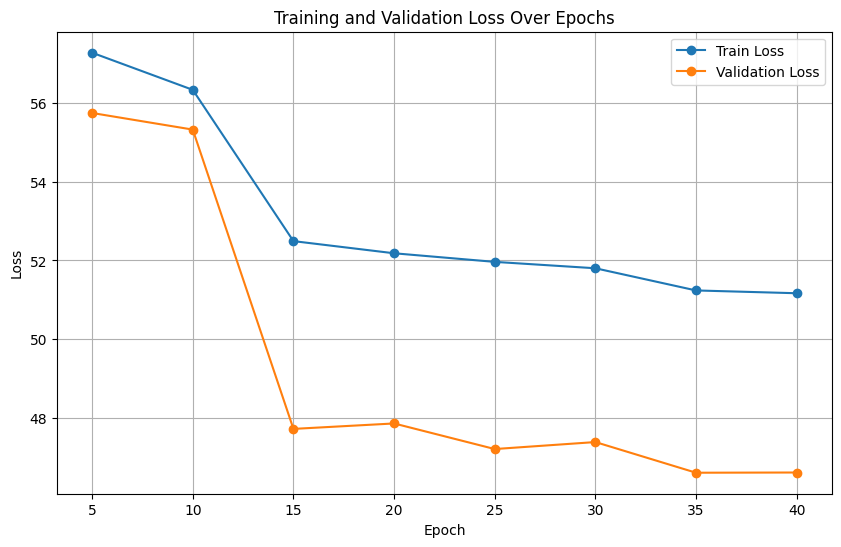

In [ ]:
# launch training with the new output_n
train(data_loader,vald_loader, path_to_save_model=model_path)

### Test Loop

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,25,skip_rate,split=2,actions=[action])
      # print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test,batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim


          all_joints_seq=batch.clone()[:, input_n:input_n+25,:]

          sequences_train=batch[:, 0:input_n, dim_used].view(-1,input_n,len(dim_used)//3,3).permute(0,3,1,2)
          sequences_gt=batch[:, input_n:input_n+25, :]


          running_time = time.time()
          sequences_predict1=model(sequences_train).view(-1, output_n, joints_to_consider, 3).permute(0,3,1,2)
          '''
          Insert your code below. You will need to iteratively predict the next frames and feed it to back to the model until you reach the desired number of frames.
          '''
          # TAKE THE PREVIOUS PREDICTION AND PLUG IT IN THE MODEL
          # DO THE SAME WITH THE NEW PREDICTION AND TAKE ONLY THE FIRST 5 FRAMES
          # THEN STACK ALL THE PREDICTION
          sequences_predict2=model(sequences_predict1).view(-1, output_n, joints_to_consider, 3).permute(0,3,1,2)
          sequences_predict3=model(sequences_predict2).view(-1, output_n, joints_to_consider, 3)[:,:5,:,:].permute(0,3,1,2)
          totalll += time.time()-running_time
          sequences_predict = torch.cat((sequences_predict1,sequences_predict2,sequences_predict3),2).permute(0,2,3,1).view(-1, 25, joints_to_consider*3)
          counter += 1

          all_joints_seq[:,:,dim_used] = sequences_predict

          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss=mpjpe_error(all_joints_seq,sequences_gt)
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)


In [ ]:
test(ckpt_path=model_path_iterative+model_name+'iter_epoch_'+'40_iter.pt')

model loaded


/content/drive/.shortcut-targets-by-id/1IDvOhof2-aw4ts2xN9XtZkYnjU34sNPy/AML_HW3/Practice/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


walking :  74.8
eating :  62.4
smoking :  62.2
discussion :  87.9
directions :  77.7
greeting :  103.5
phoning :  77.5
posing :  114.3
purchases :  101.2
sitting :  87.4
sittingdown :  114.3
takingphoto :  84.1
waiting :  82.5
walkingdog :  114.6
walkingtogether :  65.0
Average: 87.3
Prediction time:  0.013361069560050964


A way to fix the cumulative error could be the iterative mechanism, which is proposed in this exercise: this method attemps to decreasing the effect of this issue forecasting the 25 steps in different operations, in which only 10 steps per time are calculated: in some sense we want to "average" or smooth the error along the forecasting.
The plot in which training and validation losses are compared is similar to the baseline: an initial big decreasing step after that a slower decreasing trend. Moreover, like in the baseline plot, the train loss is much higher then the validation one, it may be due to too much regularization or to vanishing gradients.

The test results aren't so different compared with the baseline model, neither in average nor elementwise, but the iterative method takes about 3 times the prediction time compared to the baseline: indeed 3 is the number of prediction cicles needed to forecast 25 steps.  

## YOUR custom model (**3 Points**)
 In this exercise, you will implement a Transformer-like network (based on the Theory notebook) for this specific task. You can use the Transformer's Encoder and implement your own Decoder to predict future poses. (e.g. RNN, MLP, CNN, TCN, ...).
 We won't provide any code for this exercise, but you can use the code provided in the Theory notebook as a starting point.
 The goal of this exercise is not to beat the previous model but to understand how to implement a Transformer network for this specific task. For this reason, the evaluation will be based on the code you write and the explanation you provide in the report rather than the results.


### Performance BONUS (**Up to 2 Points**)
- **1 Bonus Point** if the model achieves an A-MPJPE between 80 and 90 millimeters.
- **2 Bonus Points** if the model achieves an A-MPJPE between 70 and 80 millimeters.


### ENCODER BLOCK
The encoder block is very similar to a typical transformer encoder, indeed the attention and multiheadattention mechanisms come from our teoretical part. 
The only things we have added is:

1. a residual connection at the end of multi-head attention module, which reduces a bit the vanish gradient;

Does it make sense? To answer this question we should show that the "xs" residual value are not affecting too much the result coming from the attention mechanism: if it is, all this amount of computation will be useless. 
Making some proves we have seen that this two quantity are of the same scale. We think that this characteristic is enough to allow us to add this detail.

2. the distillation mechanism provided in the Informer model (arXiv:2012.07436v3).

This particolar model was developed to treat time series data using transformer infrastructure and to face the computational complexity the distillation method was adopted: briefly at the end of each encoder layer a convolutional-1d layer and a MaxPooling filter were applied to halve the sequence. Instead of this, we use directly a convolutional-1d layer which reduces the frames.
This small adding decreases a lot training time, mantaining good results.

Then the model start with a $10$ frame sequence and reduces them to $8,6,4,2,1$, defining an encoder block with $5$ layers. 

### DECODER BLOCK
LSTM is an recurrent neural network used to process sequences. Due to the model's ability to learn long term sequences of observations we have choosen to adopt this model in the decoder block. It takes as hidden state the distilled information provided by the encoder block and autoregressivly it predicts the following steps. 

In [ ]:
############### Encoder ###############

class Attention(nn.Module):
    # CLASSICAL ATTENTION MECHANISM
    # IT'S THE SAME OF THE TEORICAL PART

    def __init__(self, attn_dropout):
        super().__init__()
        self.dropout = nn.Dropout(attn_dropout)
    def forward(self, query, key, value, mask=None):
        attn = torch.matmul(query, key.transpose(-2, -1))
        d_k = query.size(-1)
        attn = attn / (d_k ** 0.5)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)
        attn = self.dropout(F.softmax(attn,-1))
        output = torch.matmul(attn, value)
        return output, attn

class MultiHeadAttention(nn.Module):
    # ALSO THE MULTIHEAD ATTENTION MECHANISM IS THE SAME OF TEORICAL PART

    def __init__(self, num_heads, d_model, dropout):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        #  We assume d_v always equals d_k
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.query_ff = nn.Linear(d_model, d_model)
        self.key_ff = nn.Linear(d_model, d_model)
        self.value_ff = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        self.attention = Attention(attn_dropout=dropout)
    def forward(self, query, key, value, mask=None, return_attention=False):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        query = self.query_ff(query).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.key_ff(key).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_ff(value).view(nbatches, -1, self.num_heads, self.d_k).transpose(1, 2)
        x, self.attn = self.attention(query, key, value, mask)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.num_heads * self.d_k)
        if return_attention:
            return self.attn_ff(x), self.attn
        return x

class EncoderBlock(nn.Module):
    # THE ENCODER BLOCK IS A TIPICAL TRANSFORMER ENCODER,
    # BUT WE HAVE ADDED A CONVOLUTIONAL LAYER AT THE END:
    # self.conv IS USED TO SHRINK THE INFORMATION ALONG THE ENCODER BLOCKS 
    # THIS IS A METHOD TO DISTILL INFORMATION SHOULD BE PASSED TO THE DECODER
    # AND MOREOVER TO SAVE A LOT OF TIME

    def __init__(self,num_heads,d_model,time_in,time_out,num_joints,dropout):
        super().__init__()

        self.num_joints = num_joints
        self.d_model = d_model
        
        self.self_attn = MultiHeadAttention(num_heads, d_model, dropout)
        
        # LAYERNORM LAYERS AND DROPOUT
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
        # MLP 
        self.lin_net = nn.Sequential(
            nn.Linear(d_model,2*d_model),
            nn.ReLU(),
            nn.Linear(2*d_model,d_model),
            nn.ReLU()
        )
        
        # A CNN SHRINKS THE FRAMES FROM time_it TO time_out 
        # AND THE d_model IS HALVED AFTER EACH BLOCK
        self.conv = nn.Conv1d(time_in,time_out,3,padding=1)
            
    def forward(self, xs, mask=None):
        x = xs
        att = self.self_attn(x, x, x, mask)
        x = self.relu(x + att)
        x = self.norm1(x)

        lin_output = self.lin_net(x)
        x = self.relu(x + self.dropout(lin_output))
        
        # WE ADD A RESIDUAL CONNECTION ALSO HERE
        # IT REDUCES A BIT THE VANISH GRADIENT
        x = self.norm2(x + xs) 
        
        # SHRINK 
        x = self.conv(x)

        return x
    
############### Decoder ###############

class Decoder(nn.Module):
    # THE DECODER BLOCK IS A SIMPLE LSTM,
    # WHICH TAKES THE DISTILLED INFORMATION FROM THE
    # ENCODER AS HIDDEN STATE AND AUTOREGRESSIVLY 
    # FORSEES THE NEXT FRAMES
    def __init__(self, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        # LSTM 
        self.lstm = nn.LSTM(66, hidden_dim, num_layers=num_layers)
        # LINEAR self.out TO RETURN THE ORIGINAL DIMENSIONS 
        self.out = nn.Linear(hidden_dim, 66)
        
    def forward(self, hidden, num_steps):
        # CELL STATE IS INITIALIZED TO ZEROS
        cell = nn.Parameter(torch.zeros(*hidden.shape)).to(device)
        batch_size = hidden.size(1)
        # THE <START> IS INITIALIZED TO ONES 
        input = torch.ones((batch_size,66), dtype=torch.float).unsqueeze(0).to(device)
        outputs = torch.zeros((num_steps,batch_size,66), dtype=torch.float).to(device)

        for t in range(num_steps): 
            # FORCAST 
            decoder_output, (_,_) = self.lstm(input, (hidden,cell))
            # SET TO THE ORIGINAL DIMENSIONS
            decoder_output = self.out(decoder_output[-1])
            outputs[t] = decoder_output
            # STACK TO THE INPUT
            input = torch.cat((input,decoder_output.unsqueeze(0)),0)
        return outputs


### FINAL MODEL, WEIGHTS INITIALIZATION and POSITIONAL EMBEDDING
The final model is the end-to-end architecture which stacks the encoder and decoder modules. Building the model, weights are initialized using the He method given that the activation function most used is the Relu: this tool is applied to avoid vanishing gradients.
Furthermore the famous sinusoidal positional embeddings are used to "order" the time series for the transormer.

In [ ]:
#####################################
############ FINAL MODEL ############
##################################### 

# WE HAVE INITIALIZED THE WEIGHT USING THE HE METHOD
def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, nonlinearity='relu')

def fc_init(fc):
    nn.init.kaiming_normal_(fc.weight, nonlinearity='relu')

def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)
    
class Model(nn.Module):
    # THIS IS THE FINAL MODEL IN WHICH WE MERGED THE ENCODER AND DECODER PARTS
    def __init__(self, num_channels, num_frames_out,
                 old_frames, num_joints, num_heads, drop,
                 d_model = 512, config=None):
        super().__init__()

        # CONFIGURATION FOR THE ENCODER BLOCKS
        if config==None:
            self.config = [[d_model,10,8],[d_model,8,6],[d_model,6,4],[d_model,4,2],[d_model,2,1]]

        self.num_channels = num_channels
        self.num_frames_out = num_frames_out
        self.num_heads = num_heads
        self.num_joints = num_joints
        self.old_frames = old_frames
        self.d_model = d_model
        
        # LINEAR BLOCK TO PASS FROM INITIAL DIMENSION 66 TO d_model
        self.lin = nn.Sequential(nn.Linear(self.num_channels*self.num_joints,d_model),nn.BatchNorm1d(self.old_frames))
        self.norm = nn.BatchNorm2d(self.num_channels)
        
        # ENCODER
        self.blocks = nn.ModuleList()
        # d_ : d_model of the block;
        # in_ : number of frames of the sequences at the begin;
        # out_ : number of frames of the sequences at the end
        for index, (d_,in_) in enumerate(self.config):
            self.blocks.append(EncoderBlock(num_heads=self.num_heads,
                                            d_model=d_,time_in=in_,
                                            num_joints=self.num_joints,dropout=drop))
        
        # SINUSOIDAL POSITIONAL EMBEDDINGS
        self.pos = Pos_Embed(self.num_channels,self.old_frames,self.num_joints)
        # DECODER: HIDDEN STATE DIMENSION IS THE DIMENSION OF THE LAST ENCODER
        self.dec = Decoder(self.d_model)

        # WEIGHTS INITIALIZATION
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                conv_init(m)
            if isinstance(m, nn.Conv1d):
                conv_init(m)
            elif isinstance(m, nn.BatchNorm2d):
                bn_init(m,1)
            elif isinstance(m, nn.BatchNorm1d):
                bn_init(m,1)
            elif isinstance(m, nn.Linear):
                fc_init(m)

    def forward(self,x):
        x = x.view(-1,self.old_frames,self.num_joints,self.num_channels).permute(0,3,1,2)
        # SUM POSITIONAL EMBEDDING
        x = (x + self.pos(x)).permute(0,2,3,1).view(-1,self.old_frames,self.num_joints*self.num_channels)
        # LINEAR LAYER 
        x = self.lin(x)
        # ENCODER BLOCKS
        for i, block in enumerate(self.blocks):
            x = block(x) 
        # RETRIEVE CONTEXT FROM THE ENCODER
        context = x.view(-1,self.d_model).unsqueeze(0)
        # PASS TO THE DECODER AND RETURN THE RESULTS
        results = self.dec(hidden = context,num_steps = self.num_frames_out)
        results = results.permute(1,0,2)
        return results

### INPUT REPRESENTATION
The time series $(x_1,\dots,x_n)$ can be preprocessed and passed to the model in different ways. For what about our data there are two easy possible choices: 
1. by position: we can simply pass the data to the model as they are or rescaling by the first position: $y_n=x_n-x_0$ and $ y_0=0$;
2. by speed: the differences of the following steps with the previuos ones: $y_t=x_t-x_{t-1}$ and $ y_0=0$.

We have found that the second choice improves a lot (A LOT) the results, so it is the method provided in the notebook.

### TRAINING 
We want to adopt a iterative mechanism to test the model, indeed the fitted model predicts only $15$ output frames each time. The $d_{model}$ is setted to $512$. 
Adam is the optimizer used, initial learning rate is setted to $0.0005$ and weight decay $0.00003$. A multistep scheduler is implemented with $Gamma=0.5$ triggered on these epochs: $[2,2,2,5,5]$. The probability dropout is $p=0.3$. We run the model for $20$ epochs.


In [ ]:
# Argument for training
n_epochs = 20
log_step = 50
input_n = 10
output_n = 15

#the model name to save/load
model_path = datas+'_3d_'+str(output_n)+'frames_ckpt' 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(num_channels=3,
              num_frames_out=output_n,
              old_frames=input_n,
              num_joints=22,
              num_heads=8,
              drop=0.3).to(device)

# Arguments to setup the optimizer
lr=5e-04 # learning rate
use_scheduler=True # use MultiStepLR scheduler
milestones=[2,2,2,5,5]   # the epochs after which the learning rate is adjusted by gamma
gamma=0.5 #gamma correction to the learning rate, after reaching the milestone epochs
weight_decay=0.00003 # weight decay (L2 penalty)
optimizer=optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

if use_scheduler:
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [ ]:
# WE HAVE REWRITE THE TRAIN FUNCTION 
# TO IMPLEMENT THE SPEED REPRESENTATION

save_and_plot = True
def train_final(data_loader,vald_loader):
  train_loss = []
  val_loss = []
  val_loss_best = 1000

  # Initialize lists to store data from each checkpoint
  train_losses = []
  val_losses = []

  dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                    26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                    46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                    75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])

  for epoch in range(n_epochs):
      running_loss=0
      n=0
      model.train()
      for cnt,batch in enumerate(data_loader):
          batch=batch.float().to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim
          
          # GET SPEED REPRESENTATION:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),batch[:,1:10,dim_used]-batch[:,:9,dim_used]),1)
          sequences_gt=batch[:, input_n:input_n+output_n, dim_used]

          optimizer.zero_grad()
          sequences_predict=model(sequences_train)
          # COME BACK POSITIONAL REPRESENTATION:
          # SUM EACH FRAME TO THE NEXT 
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict[:,1:output_n,:]=sequences_predict[:,1:output_n,:]+sequences_predict[:,:output_n-1,:]
          sequences_predict=(sequences_predict+batch[:,(input_n-1):input_n,dim_used])


          loss=mpjpe_error(sequences_predict,sequences_gt)/output_n


          if cnt % log_step == 0:
            print('[Epoch: %d, Iteration: %5d]  training loss: %.3f' %(epoch + 1, cnt + 1, loss.item()*output_n))

          loss.backward()
          if clip_grad is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(),clip_grad)

          optimizer.step()
          running_loss += loss*batch_dim*output_n

      train_loss.append(running_loss.detach().cpu()/n)
      model.eval()
      with torch.no_grad():
          running_loss=0
          n=0
          for cnt,batch in enumerate(vald_loader):
              batch=batch.float().to(device)
              batch_dim=batch.shape[0]
              n+=batch_dim

              # GET SPEED REPRESENTATION:
              # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
              # Y_{N+1} = X_{N+1} - X_{N}
              sequences_train=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),batch[:,1:input_n,dim_used]-batch[:,:input_n-1,dim_used]),1)
              sequences_gt=batch[:, input_n:input_n+output_n, dim_used]

              sequences_predict=model(sequences_train)
              
              # COME BACK POSITIONAL REPRESENTATION:
              # SUM EACH FRAME TO THE NEXT 
              # X_{N+1} = Y_{N+1} + Y_{N}
              # ADD THE LAST FRAME OF THE TRAIN ONES
              sequences_predict[:,1:output_n,:]=sequences_predict[:,1:output_n,:]+sequences_predict[:,:(output_n-1),:]
              sequences_predict=(sequences_predict+batch[:,(input_n-1):input_n,dim_used])
              loss=mpjpe_error(sequences_predict,sequences_gt)/output_n

              if cnt % log_step == 0:
                        print('[Epoch: %d, Iteration: %5d]  validation loss: %.3f' %(epoch + 1, cnt + 1, loss.item()*output_n))
              running_loss+=loss*batch_dim*output_n
          val_loss.append(running_loss.detach().cpu()/n)
          if running_loss/n < val_loss_best:
            val_loss_best = running_loss/n
          if (epoch+1) % 5 == 0:
            torch.save(model.state_dict(), './checkpoints/final_checkpoint'+str(epoch+1)+'.pt')
            train_losses.append(train_loss[-1])
            val_losses.append(val_loss[-1])

  if use_scheduler:
    scheduler.step()

  epochs=[5,10,15,20]

  # Create the plot
  plt.figure(figsize=(10, 6))
  plt.plot(epochs, train_losses, label='Train Loss', marker='o')
  plt.plot(epochs, val_losses, label='Validation Loss', marker='o')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss Over Epochs')

  plt.legend()

  # Display the plot
  plt.grid(True)
  plt.show()
  return train_losses,val_losses

[Epoch: 1, Iteration:     1]  training loss: 79.184
[Epoch: 1, Iteration:    51]  training loss: 78.934
[Epoch: 1, Iteration:   101]  training loss: 73.088
[Epoch: 1, Iteration:   151]  training loss: 72.825
[Epoch: 1, Iteration:   201]  training loss: 73.612
[Epoch: 1, Iteration:   251]  training loss: 73.535
[Epoch: 1, Iteration:   301]  training loss: 74.763
[Epoch: 1, Iteration:   351]  training loss: 75.150
[Epoch: 1, Iteration:   401]  training loss: 68.661
[Epoch: 1, Iteration:   451]  training loss: 67.022
[Epoch: 1, Iteration:   501]  training loss: 72.236
[Epoch: 1, Iteration:   551]  training loss: 68.081
[Epoch: 1, Iteration:   601]  training loss: 69.477
[Epoch: 1, Iteration:   651]  training loss: 69.463
[Epoch: 1, Iteration:   701]  training loss: 60.985
[Epoch: 1, Iteration:     1]  validation loss: 57.496
[Epoch: 1, Iteration:    51]  validation loss: 55.966
[Epoch: 1, Iteration:   101]  validation loss: 55.748
[Epoch: 2, Iteration:     1]  training loss: 69.830
[Epoch

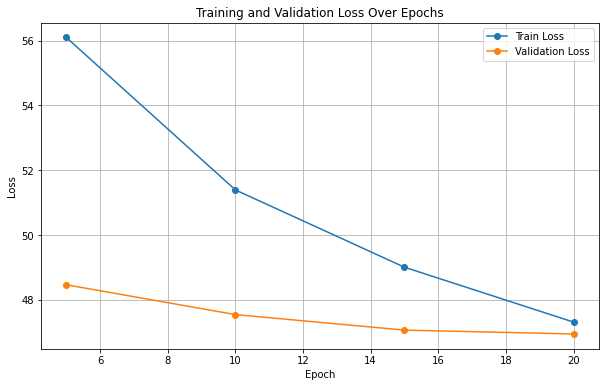

In [ ]:
t_loss,v_loss = train_final(data_loader,vald_loader)

### ANALYSIS TRAIN-VALIDATION RESULTS
We have tried different values for regularization parameter (dropout and weight_decay) and for the learning rate: 
We think that a better choices for the scheduler (both number and positions of the steps and the type of scheduler) could still improve the model output, because we found that changing the lr very little affects a lot the results. For what about the regolarization, this type of tuning influnces less the final value then what we could expect. 

As happened above, the validation loss is always smaller then the train loss. But instead of before they converge at the same value. 
Nevertheless, we had also tried to set to zero the regolarization effect this discrepancy persists: this convince us that the choices done in the schedelur implementation can be refined. 

The results of the validation loss comparing with the iterative mechanism one are very similar but our model predicts $5$ steps more then the previous. 

In [ ]:
def test(ckpt_path=None):
    model.load_state_dict(torch.load(ckpt_path))
    print('model loaded')
    model.eval()
    accum_loss=0
    n_batches=0 # number of batches for all the sequences
    actions=define_actions(actions_to_consider_test)
    dim_used = np.array([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
                      26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                      46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 59, 63, 64, 65, 66, 67, 68,
                      75, 76, 77, 78, 79, 80, 81, 82, 83, 87, 88, 89, 90, 91, 92])
    # joints at same loc
    joint_to_ignore = np.array([16, 20, 23, 24, 28, 31])
    
    index_to_ignore = np.concatenate((joint_to_ignore * 3, joint_to_ignore * 3 + 1, joint_to_ignore * 3 + 2))
    joint_equal = np.array([13, 19, 22, 13, 27, 30])
    index_to_equal = np.concatenate((joint_equal * 3, joint_equal * 3 + 1, joint_equal * 3 + 2))
    totalll=0
    counter=0
    for action in actions:
      running_loss=0
      n=0
      dataset_test = datasets.Datasets(path,input_n,25,skip_rate, split=2,actions=[action])
      #print('>>> test action for sequences: {:d}'.format(dataset_test.__len__()))

      test_loader = DataLoader(dataset_test, batch_size=batch_size_test, shuffle=False, num_workers=0, pin_memory=True)
      for cnt,batch in enumerate(test_loader):
        with torch.no_grad():

          batch=batch.to(device)
          batch_dim=batch.shape[0]
          n+=batch_dim

          all_joints_seq=batch.clone()[:, input_n:input_n+25,:]

          # GET SPEED REPRESENTATION OF THE FIRST FRAMES:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train1=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),batch[:,1:input_n,dim_used]-batch[:,:(input_n-1),dim_used]),1)
          sequences_gt=batch[:,10:35,:]

          
          running_time = time.time()
          sequences_predict1 = model(sequences_train1)

          # COME BACK POSITIONAL REPRESENTATION OF THE FIRST PREDICTION:
          # SUM EACH FRAME TO THE NEXT 
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict1[:,1:output_n,:]=sequences_predict1[:,1:output_n,:]+sequences_predict1[:,:(output_n-1),:]
          sequences_predict1=(sequences_predict1+batch[:,(input_n-1):input_n,dim_used])
          
          # GET SPEED REPRESENTATION OF THE PREDICTED STEPS:
          # SET THE FIRST FRAME TO ZERO AND CALCULATE THE SPEED AS
          # Y_{N+1} = X_{N+1} - X_{N}
          sequences_train2=torch.cat((torch.zeros(*batch[:,:1,dim_used].size()).to(device),
                                     sequences_predict1[:,6:15,:]-sequences_predict1[:,5:14,:]),1)
          
          sequences_predict2=model(sequences_train2)

          # COME BACK POSITIONAL REPRESENTATION OF THE SECOND PREDICTION:
          # SUM EACH FRAME TO THE NEXT 
          # X_{N+1} = Y_{N+1} + Y_{N}
          # ADD THE LAST FRAME OF THE TRAIN ONES
          sequences_predict2[:,1:output_n,:]=sequences_predict2[:,1:output_n,:]+sequences_predict2[:,:(output_n-1),:]
          sequences_predict2=(sequences_predict2+sequences_predict1[:,(output_n-1):output_n,:])
          
          # STACK THE TWO PREDICTED SEQUENCES
          sequences_predict = torch.cat((sequences_predict1,sequences_predict2[:,:10,:]),1)
          
          totalll += time.time()-running_time
          counter += 1

          all_joints_seq[:,:,dim_used] = sequences_predict


          all_joints_seq[:,:,index_to_ignore] = all_joints_seq[:,:,index_to_equal]

          loss=mpjpe_error(all_joints_seq.view(-1,25,32,3),sequences_gt.view(-1,25,32,3))
          running_loss+=loss*batch_dim
          accum_loss+=loss*batch_dim

      #print('loss at test subject for action : '+str(action)+ ' is: '+ str(running_loss/n))
      print(str(action),': ', str(np.round((running_loss/n).item(),1)))
      n_batches+=n
    print('Average: '+str(np.round((accum_loss/n_batches).item(),1)))
    print('Prediction time: ', totalll/counter)

In [ ]:
test()

/kaggle/input/data-aml/utils/h36motion3d.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subs = np.array([[1, 6, 7, 8, 9], [11], [5]]) # , 6, 7, 8, 9


walking :  57.5
eating :  49.5
smoking :  48.6
discussion :  83.0
directions :  72.1
greeting :  99.1
phoning :  65.4
posing :  105.2
purchases :  92.0
sitting :  71.5
sittingdown :  91.8
takingphoto :  70.5
waiting :  72.0
walkingdog :  101.4
walkingtogether :  53.8
Average: 75.6
Prediction time:  0.018187958002090453
